In [91]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [92]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [93]:
train = pd.read_csv(open('train.csv'), sep = ',')
test = pd.read_csv(open('test.csv'), sep = ',')
train.shape, test.shape

((1460, 81), (1459, 80))

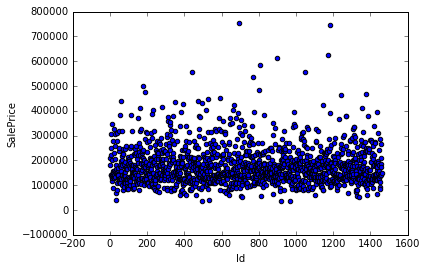

In [94]:
#Scatter plot of Id vs Sale Price
data = train[['Id','SalePrice']].values
#Plot part
plt.scatter(data[:,0],data[:,1]);
plt.xlabel('Id');
plt.ylabel('SalePrice');

In [95]:
type(train),type(test)


(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

In [96]:
train.isnull().values.any(),train.isnull().sum().sum()

(True, 6965)

In [97]:
train.isnull().values.sum().sum()

6965

In [98]:
train.shape, test.shape

((1460, 81), (1459, 80))

In [99]:
#Concat train and test data so as to avoid mismatch of number of features after applying pandas_dataframe.get_dummies
train_test_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],test.loc[:,'MSSubClass':'SaleCondition']))
train_test_data.shape

(2919, 79)

Categorical caolumns

In [100]:
categorical_columns = []
for column in train_test_data.columns.values:
    if train_test_data[column].dtype == 'object':
        categorical_columns.append(column)
    

In [101]:
train_numerical = train_test_data.drop(categorical_columns, axis=1)
train_categorical = train_test_data[categorical_columns]
train_numerical.shape, train_categorical.shape

((2919, 36), (2919, 43))

Numerical data imputation

In [103]:
from scipy.stats import skew
from sklearn.preprocessing import Normalizer
for column in train_numerical.columns.values:
    if(train_numerical[column].isnull().sum().sum() > 100):
        train_numerical = train_numerical.drop(column, axis = 1)
    elif (train_numerical[column].isnull().sum().sum() > 0):
        train_numerical = train_numerical.fillna(train_numerical[column].median())
    
    outlier = np.where(is_outlier(train_numerical[column]))
    train_numerical[column].iloc[outlier] = train_numerical[column].median()
    
    '''
    if skew(xTrain[column]) > 0.75 :
        
    '''
    if skew(train_numerical[column]) > 0.75:
        train_numerical[column] = np.log(train_numerical[column])
        train_numerical[column] = train_numerical[column].apply(lambda x: 0 if x == -np.inf else x)
        
        train_numerical[column] = Normalizer().fit_transform(train_numerical[column].reshape(1,-1))[0]
    

Categorical data imputation

In [104]:
for column in train_categorical.columns.values:
    if(train_categorical[column].isnull().sum().sum() > 100):
        train_categorical = train_categorical.drop(column, axis = 1)
        continue
    elif (train_categorical[column].isnull().sum().sum() > 0):
        train_categorical[column] = train_categorical.fillna(train_categorical[column].value_counts().index[0])

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [105]:
#Convert categorical variable into dummy/indicator variables
train_categorical = pd.get_dummies(train_categorical)
train_categorical.shape

(2919, 194)

In [106]:
train_test_data_new = train_numerical.join(train_categorical)
train_test_data_new.shape, train_numerical.shape, train_categorical.shape

((5837, 229), (2919, 35), (2919, 194))

In [107]:
train_rows = int(train.shape[0] * 0.8)
val_rows = train.shape[0] - train_rows
train_rows, val_rows

(1168, 292)

In [108]:
#Train partition
xTrain = train_test_data_new.iloc[:train.shape[0],:]
tTrain = train.loc[:train.shape[0] ,'SalePrice']

"""
xTrain = train_test_data_new.iloc[:train_rows,:]
tTrain = train.loc[:train_rows -1 ,'SalePrice']
"""

"""
#Validation partition
vTrain = train_test_data_new.iloc[train_rows:train.shape[0],:]
vtTrain = train.loc[train_rows:train.shape[0],'SalePrice']
"""


#xTest partition
xTest = train_test_data_new.iloc[train.shape[0]:,:]


In [109]:
type(tTrain.values)

numpy.ndarray

In [110]:
tTrain = pd.DataFrame(np.log1p(tTrain.values))

In [111]:
train_test_data_new.shape, xTrain.shape, tTrain.shape, vTrain.shape, vtTrain.shape, xTest.shape

((5837, 229), (1460, 229), (1460, 1), (292, 229), (292,), (4377, 229))

In [112]:
#Random Forest Classifier
from sklearn.ensemble import RandomForestRegressor
'''
The value of n_estimators is kept high so as to have stability of RandomForest; 
If we take lower values of n_estimotros, we'll observe the variation in importance 
of features calculated next.
'''
clf = RandomForestRegressor(n_estimators=500, n_jobs=-1)
clf = clf.fit(xTrain,tTrain)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [113]:
'''Get names of the features of entire data'''
names = list(train_test_data_new.columns.values)
'''Get the feature importance of RandomForest'''
importances = clf.feature_importances_
#print len(importance)

In [114]:
'''Map sorted feature importance and names of features'''
print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), importances),names), 
             reverse=True)

Features sorted by their score:
[(0.0664, 'LotArea'), (0.0582, 'BsmtUnfSF'), (0.0543, 'GarageArea'), (0.0526, 'GrLivArea'), (0.0489, '1stFlrSF'), (0.0448, 'BsmtFinSF1'), (0.0437, 'TotalBsmtSF'), (0.0421, 'MoSold'), (0.035, 'OpenPorchSF'), (0.0338, 'YearRemodAdd'), (0.0312, 'GarageYrBlt'), (0.0298, 'YearBuilt'), (0.021, 'TotRmsAbvGrd'), (0.0204, 'YrSold'), (0.0167, 'OverallQual'), (0.0137, 'Fireplaces'), (0.0128, 'MSSubClass'), (0.0089, 'Neighborhood_CollgCr'), (0.0087, 'HouseStyle_SLvl'), (0.0086, 'HeatingQC_Ex'), (0.008, 'Neighborhood_NAmes'), (0.0078, 'HouseStyle_1Story'), (0.0078, 'HeatingQC_Gd'), (0.0077, 'LotConfig_Inside'), (0.0072, 'LotConfig_Corner'), (0.0071, 'ExterCond_Gd'), (0.007, 'LotShape_IR1'), (0.007, 'HeatingQC_TA'), (0.0069, 'RoofStyle_Gable'), (0.0068, 'HouseStyle_2Story'), (0.0064, 'ExterQual_TA'), (0.0064, 'ExterCond_TA'), (0.0062, 'Neighborhood_Gilbert'), (0.0062, 'LotShape_Reg'), (0.0062, 'ExterQual_Gd'), (0.0061, 'Neighborhood_NridgHt'), (0.0061, 'HouseStyle_1.5

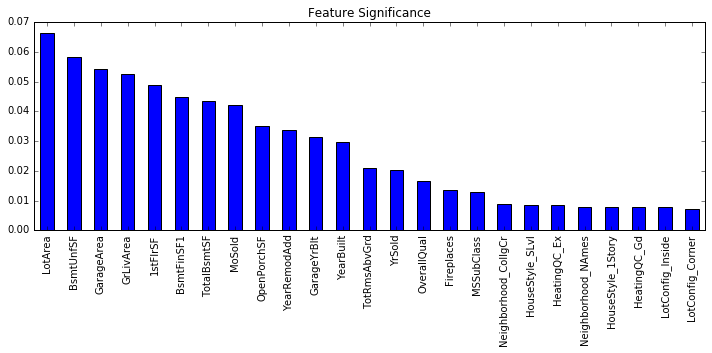

In [115]:
sorted_importances = pd.Series(importances, index = train_test_data_new.columns).sort_values(ascending=False)
sorted_importances = pd.Series(sorted_importances)
plt.figure(figsize=(10, 5))
sorted_importances.head(25).plot(kind='bar')
plt.title('Feature Significance')
plt.tight_layout()

In [116]:
'''Validation'''
val_prediction = clf.predict(vTrain)
val_prediction.shape
vtTrain_actual = vtTrain.to_frame().loc[:,'SalePrice'].values
len(vtTrain_actual), len(val_prediction)

(292, 292)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


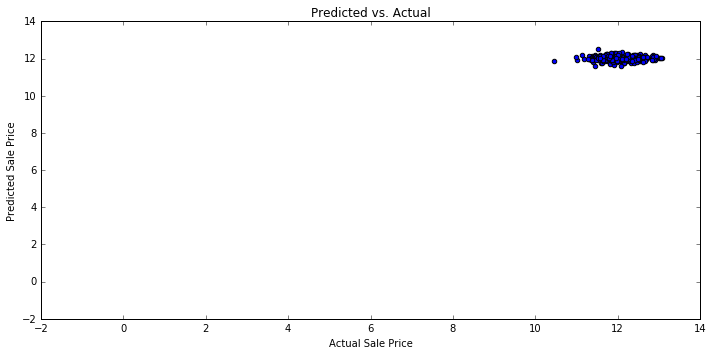

In [118]:
from sklearn.cross_validation import train_test_split

X_train1, X_test1, y_train1, y_test1 = train_test_split(xTrain, tTrain)
clf = RandomForestRegressor(n_estimators=500, n_jobs=-1)

clf.fit(X_train1, y_train1)
y_pred = clf.predict(X_test1)

plt.figure(figsize=(10, 5))
plt.scatter(y_test1, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test1), max(y_test1)], [min(y_test1), max(y_test1)])
plt.tight_layout()

In [119]:
from sklearn.metrics import mean_squared_error
from math import sqrt
print "Accuracy", sqrt(mean_squared_error(val_prediction, vtTrain_actual, multioutput='raw_values'))

Accuracy 199785.231325


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:1531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:1531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:1531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/2.7/lib/p

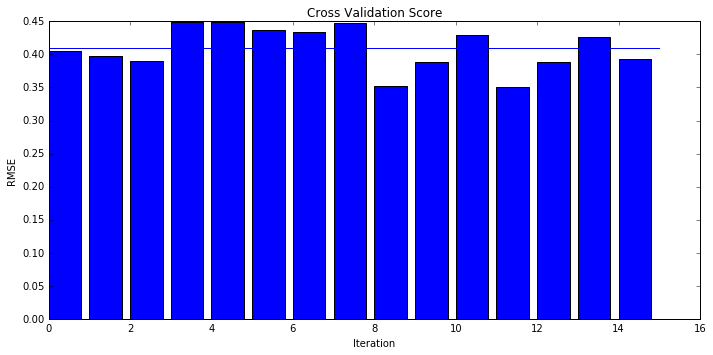

In [120]:
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.cross_validation import cross_val_score

scorer = make_scorer(mean_squared_error, False)

clf = RandomForestRegressor(n_estimators=500, n_jobs=-1)
cv_score = np.sqrt(-cross_val_score(estimator=clf, X=xTrain, y=tTrain, cv=15, scoring = scorer))

plt.figure(figsize=(10,5))
plt.bar(range(len(cv_score)), cv_score)
plt.title('Cross Validation Score')
plt.ylabel('RMSE')
plt.xlabel('Iteration')

plt.plot(range(len(cv_score) + 1), [cv_score.mean()] * (len(cv_score) + 1))
plt.tight_layout()